This project is aimed at analysing the dataset available at https://springernature.figshare.com/articles/dataset/Open_access_dataset_integrating_EEG_and_fNIRS_during_Stroop_tasks/24032265?backTo=/collections/Open_access_dataset_integrating_EEG_and_fNIRS_during_Stroop_tasks/6623431
with complex network analysis methodologies. 

*Objective*:
Examine the patterns of connectivity across 21 participants data that was gathered with 20 channels fnirs, when a Stroop test was administered.

Resources:
* DATASET: https://springernature.figshare.com/articles/dataset/Open_access_dataset_integrating_EEG_and_fNIRS_during_Stroop_tasks/24032265?backTo=/collections/Open_access_dataset_integrating_EEG_and_fNIRS_during_Stroop_tasks/6623431
* PAPER: https://www.nature.com/articles/s41597-023-02524-1

Tools:
* MNE python
* Networkx

***IMPORTS***

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

***Step 1: Adjacency matrices***

Load the HbO_I_1, HbO_I_2, HbO_N_1, HbO_N_2 into pandas dataframes, downsample the timeseries to 0.5Hz (data is preprocessed with bandpass filters in the 0.01 and 0.2Hz range) and calculate the  adjacency matrix across the 21 sheets of each file to construct the graph time-series.
Row by row (2 sec step), the adjacency matrix are calculated using the Pearson correlation and taking the absolute value of the coefficients. The sequences are saved on .h5 format

In [2]:
# Calculate the adjacency matrix using Pearson correlation
def calculate_adjacency_matrix(df):
    # Calculate the Pearson correlation matrix and return the adjacency matrix
    correlation_matrix = df.corr()
    adjacency_matrix = np.abs(correlation_matrix)

    return adjacency_matrix


# List all data paths:
file_path_HbO_I_1 = 'fNIRS-EEG_Stroop/Pre-processed Data/Pre-processed fNIRS Data/Pre-Preocessed fNIRS Data In csv/HbO_I_1.xls'  
file_path_HbO_I_2 = 'fNIRS-EEG_Stroop/Pre-processed Data/Pre-processed fNIRS Data/Pre-Preocessed fNIRS Data In csv/HbO_I_2.xls'  
file_path_HbO_N_1 = 'fNIRS-EEG_Stroop/Pre-processed Data/Pre-processed fNIRS Data/Pre-Preocessed fNIRS Data In csv/HbO_N_1.xls' 
file_path_HbO_N_2 = 'fNIRS-EEG_Stroop/Pre-processed Data/Pre-processed fNIRS Data/Pre-Preocessed fNIRS Data In csv/HbO_N_2.xls'  

#file_paths = [file_path_HbO_I_1, file_path_HbO_I_2, file_path_HbO_N_1, file_path_HbO_N_2]
file_paths = [file_path_HbO_N_1, file_path_HbO_N_2, file_path_HbO_I_1, file_path_HbO_I_2]


# Downsampling parameters
original_rate = 100  # Original sampling rate (100 Hz)
downsampled_rate = 2  # New sampling rate (0.5 Hz)
window_size = int(original_rate / downsampled_rate)  # Window size for downsampling
time_interval = 1/downsampled_rate


for file_path in file_paths:

# Load all sheets
    all_sheets = pd.read_excel(file_path, sheet_name=None)

    # Downsample each sheet
    downsampled_sheets = {}
    for sheet_name, data in all_sheets.items():
        downsampled_data = data.groupby(np.arange(len(data)) // window_size).mean()
        downsampled_sheets[sheet_name] = downsampled_data

    # List to store the adjacency matrices for the current file
    file_adjacency_matrices = []
    num_time_points = len(downsampled_sheets[list(downsampled_sheets.keys())[0]])   
    for time_point in range(num_time_points):
        # Extract data row for this time point across all sheets and save it in a list of dfs
        time_point_data = [sheet.iloc[time_point] for sheet in downsampled_sheets.values()]

        # List to dataframe
        time_point_df = pd.DataFrame([serie.tolist() for serie in time_point_data])

        # Calculate the adjacency matrix
        adjacency_matrix = calculate_adjacency_matrix(time_point_df)

        file_adjacency_matrices.append(adjacency_matrix)

    # Save the matrices sequences to .h5 files
    with pd.HDFStore(f'{file_path.removesuffix(".xls")}.h5', 'w') as store: 
        for time_point, matrix in enumerate(file_adjacency_matrices):
            store.put(f'matrix_{time_point}', matrix)





***Step 2: generate the networks***

Load the matrices and study the data for a threshold value for correlation. 


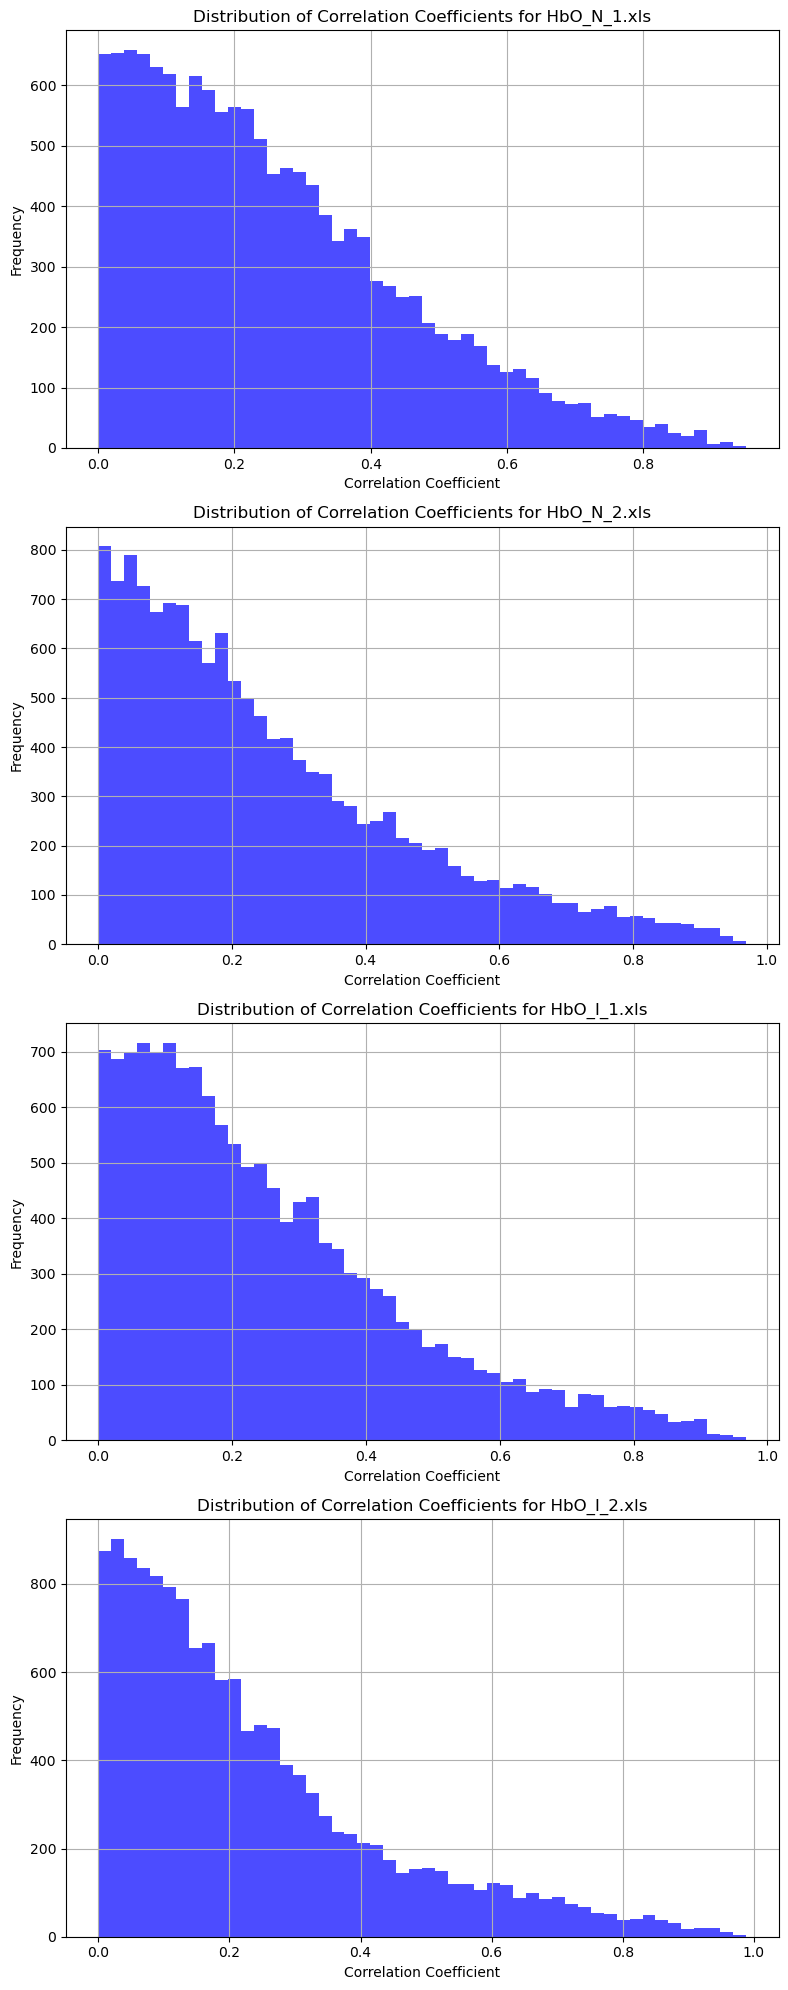

In [3]:
# Setup for plotting in a grid
num_files = len(file_paths)
plt.figure(figsize=(8, num_files * 5))

# Loop over each file and plot
for idx, file_path in enumerate(file_paths, 1):
    # Load the matrices from the HDF5 file
    with pd.HDFStore(file_path.removesuffix(".xls") + '.h5', 'r') as store:
        loaded_matrices = [store[f'matrix_{i}'] for i in range(len(store.keys()))]

    # Extract correlation coefficients
    correlation_values = []
    for matrix in loaded_matrices:
        upper_tri = matrix.where(np.triu(np.ones(matrix.shape), k=1).astype(bool))
        correlation_values.extend(upper_tri.stack())

    # Convert the list to a DataFrame
    correlation_df = pd.DataFrame(correlation_values, columns=['correlation'])
    

    # Plotting
    plt.subplot(num_files, 1, idx)
    plt.hist(correlation_df['correlation'], bins=50, color='blue', alpha=0.7)
    plt.title(f'Distribution of Correlation Coefficients for {file_path.split("/")[-1]}')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Frequency')
    plt.grid(True)

  
plt.tight_layout()
plt.show()

***Step 3: temporal analysis of properties***

Construct the network at each timestamp. Threshold is set at 0.4 to filter out weak correlations.
To simplify the analysis, as literature shows, I binarize the correlation values around the threshold to establish whether or not there's a connection/edge between nodes, without considering any weight


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


75


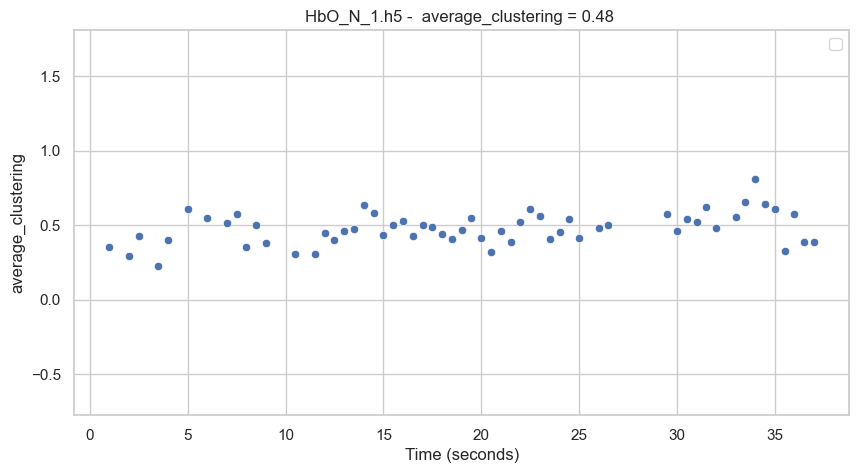

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


75


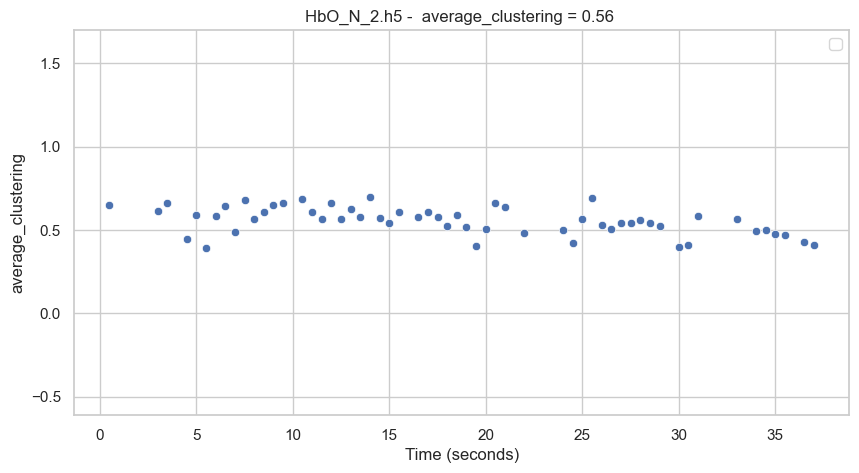

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


75


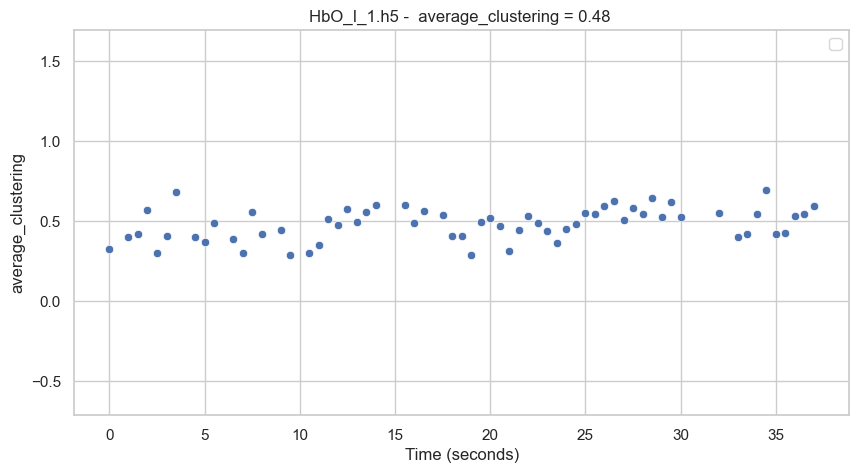

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


75


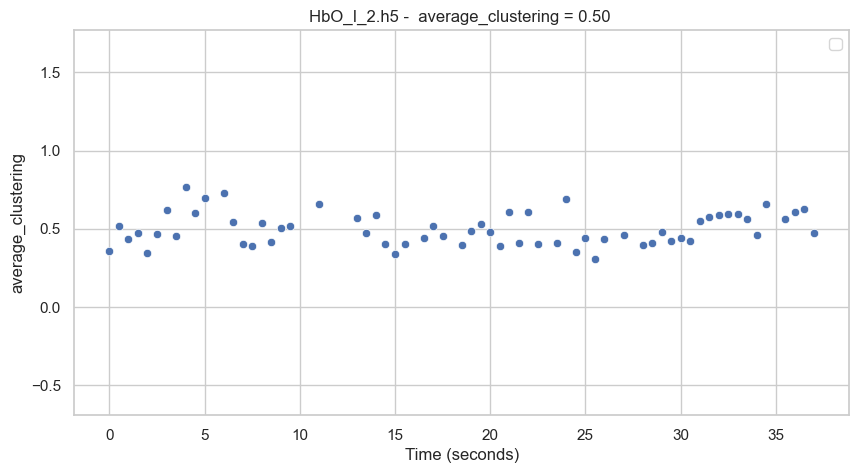

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


75


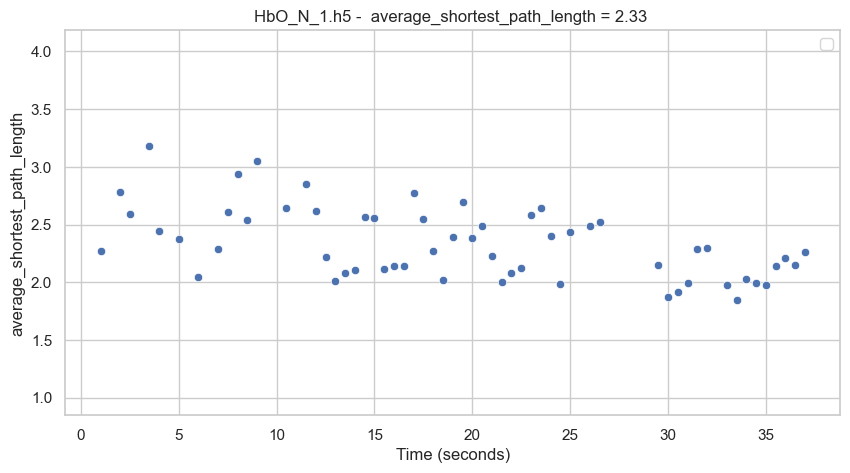

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


75


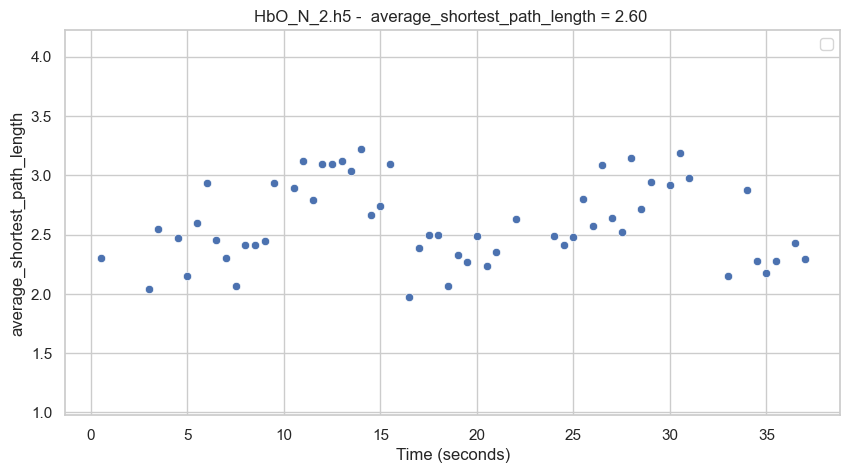

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


75


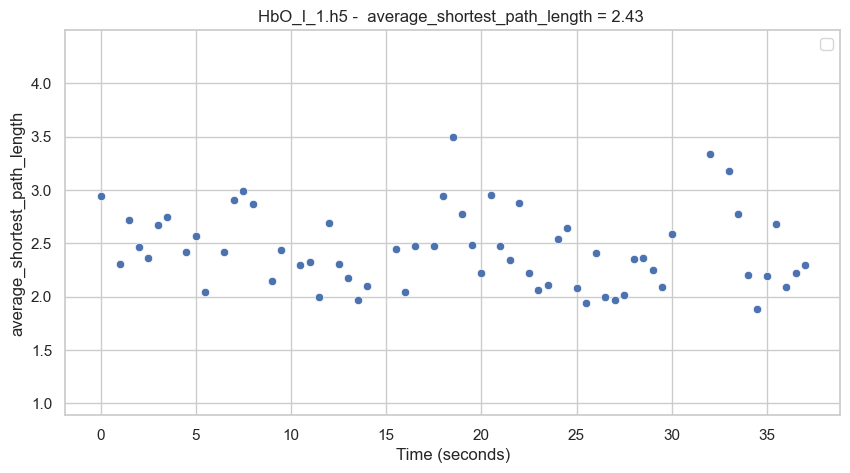

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


75


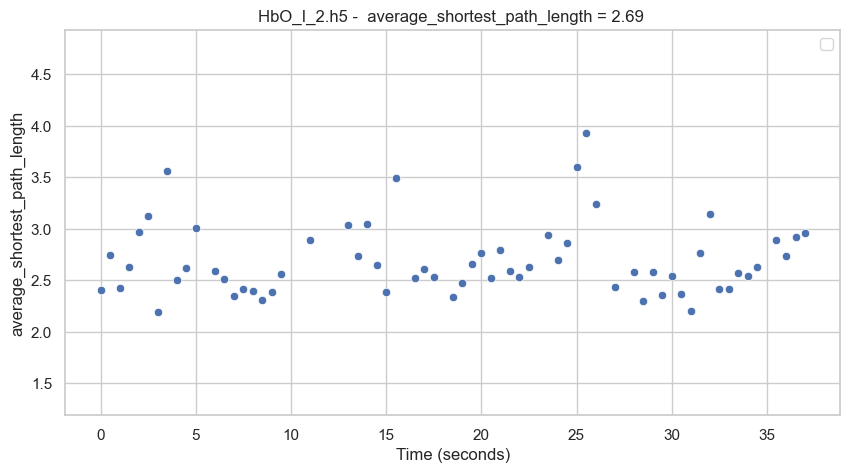

In [28]:
# file paths containing the timeseries of correlation matrices
h5_file_paths = [
    'fNIRS-EEG_Stroop/Pre-processed Data/Pre-processed fNIRS Data/Pre-Preocessed fNIRS Data In csv/HbO_N_1.h5',
    'fNIRS-EEG_Stroop/Pre-processed Data/Pre-processed fNIRS Data/Pre-Preocessed fNIRS Data In csv/HbO_N_2.h5',
    'fNIRS-EEG_Stroop/Pre-processed Data/Pre-processed fNIRS Data/Pre-Preocessed fNIRS Data In csv/HbO_I_1.h5',
    'fNIRS-EEG_Stroop/Pre-processed Data/Pre-processed fNIRS Data/Pre-Preocessed fNIRS Data In csv/HbO_I_2.h5'

]

# Threshold for including an edge in the network
correlation_threshold = 0.4 # 
properties_list =[]
# Function to load the matrices from a given HDF5 file
def load_matrices_from_hdf5(file_path):
    with pd.HDFStore(file_path, 'r') as store:
        loaded_matrices = [store[f'matrix_{i}'] for i in range(len(store.keys()))]
    return loaded_matrices

# Function to construct a network from a correlation matrix
def construct_network_from_matrix(matrix, threshold):
    G = nx.Graph()
    for i in range(len(matrix.columns)):
        for j in range(i+1, len(matrix.columns)):
            if abs(matrix.iloc[i, j]) > threshold:
                G.add_edge(matrix.columns[i], matrix.columns[j])
    return G

# Function to calculate network properties
def calculate_network_properties(G):
    # If the graph is empty or not connected, return None for properties
    if len(G) == 0 or not nx.is_connected(G):
        
        return {
        'average_clustering': np.nan,
        'average_shortest_path_length': np.nan,
        'degree_centrality': np.nan,
        'betweenness_centrality': np.nan,
        'eigenvector_centrality': np.nan,
        'largest_cc_size': np.nan 
    }
    
    
    properties = {
        'average_clustering': nx.average_clustering(G),
        'average_shortest_path_length': nx.average_shortest_path_length(G),
        'degree_centrality': nx.degree_centrality(G),
        'betweenness_centrality': nx.betweenness_centrality(G),
        'eigenvector_centrality': nx.eigenvector_centrality(G, max_iter=1000),
        'largest_cc_size': len(max(nx.connected_components(G), key=len))
    }
    return properties

# Function to plot the properties over time
def plot_properties_over_time(properties_over_time, property_name, time_interval, filename):
    sns.set(style='whitegrid')

    values = [prop[property_name] for prop in properties_over_time if prop is not None]
    time_points = [i * time_interval for i in range(len(values))]

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.scatterplot(x=time_points,y=values, legend="auto", ax=ax)
    plt.ylim(np.nanmin(values)-1,np.nanmax(values)+1)
    #plt.plot(time_points,values, marker='o')
    
    avg_value = np.nanmean(values)
    plt.title(f'{filename} -  {property_name} = {avg_value:.2f} ')
    plt.xlabel('Time (seconds)')
    plt.ylabel(property_name)
    plt.grid(True)
    plt.legend()
    plt.show()
    plt.close(fig)

# Function to process all networks for a given file
def process_networks(file_path, threshold):
    matrices = load_matrices_from_hdf5(file_path)
    networks = [construct_network_from_matrix(m, threshold) for m in matrices]
    properties_over_time = [calculate_network_properties(G) for G in networks]
    print(len(properties_over_time))
    return properties_over_time

# Function to run the entire process for each file and plot a given property
def analyze_files_and_plot_property(h5_file_paths, property_name, time_interval,threshold):
    for file_path in h5_file_paths:
        properties_over_time = process_networks(file_path, threshold)
        properties_list.append(properties_over_time)
        filename = file_path.split('/')[-1]
        plot_properties_over_time(properties_over_time, property_name, time_interval, filename)

# Process all files and plot the 'average_clustering' property

properties_to_plot = ['average_clustering',
        'average_shortest_path_length']
for property in properties_to_plot:
    analyze_files_and_plot_property(h5_file_paths, property,time_interval,correlation_threshold)



***Step 4: Small-world hypothesis***

Let's analyze the network properties at each timestamp and verify the hypothesis of small-worldness over time.

In [5]:
# Dicts to store small-world coefficients dicts for all files
coefficients_files = []

def small_world_analysis(file_path, threshold=0.4):
    matrices = load_matrices_from_hdf5(file_path)
    networks = [construct_network_from_matrix(m, threshold) for m in matrices]
   
    omega_coefficients =[]
    sigma_coefficients =[]
    for G in networks:
        # Skip empty or disconnected graphs
        if not nx.is_connected(G):
            omega_coefficients.append(None)
            sigma_coefficients.append(None)
            continue

        # Properties of the real network
        real_clustering = nx.average_clustering(G)
        real_path_length = nx.average_shortest_path_length(G)

        # Properties of random network
        random_network = nx.random_reference(G,seed=42)
         # Use largest connected component for path length
        largest_cc_nodes = max(nx.connected_components(random_network), key=len)
        largest_cc = random_network.subgraph(largest_cc_nodes)

        random_path_length = nx.average_shortest_path_length(largest_cc) 
        random_clustering = nx.average_clustering(random_network)

        lattice_network = nx.lattice_reference(G,seed=42)
        lattice_clustering = nx.average_clustering(lattice_network)

        # Small-world coefficient
        # Omega
        omega =  (random_path_length / real_path_length) - (real_clustering / lattice_clustering) 
   
        omega_coefficients.append(omega)

        # Sigma
        sigma =  (real_clustering / random_clustering) /(real_path_length / random_path_length) 
        #sigma = nx.smallworld.sigma(G,seed=42)

        sigma_coefficients.append(sigma)
        
    return sigma_coefficients, omega_coefficients

for file_path in h5_file_paths:
    coefficients_files.append( small_world_analysis(file_path, threshold=correlation_threshold))

# Delete clone elements in properties list

properties_list = properties_list[:-4]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


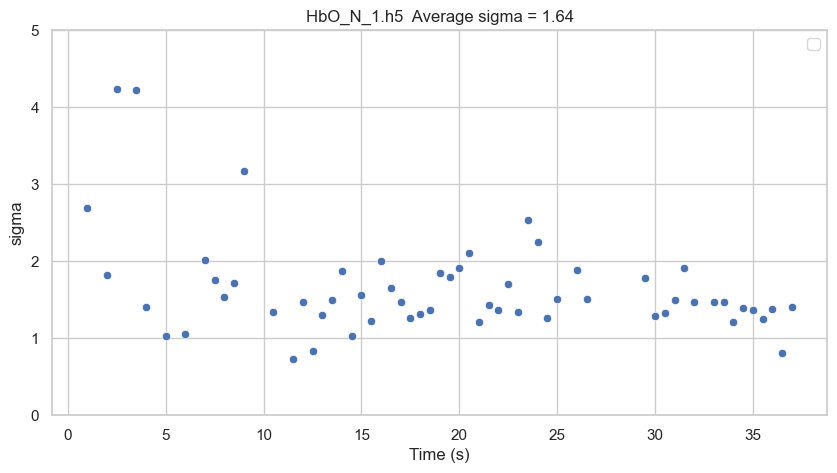

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


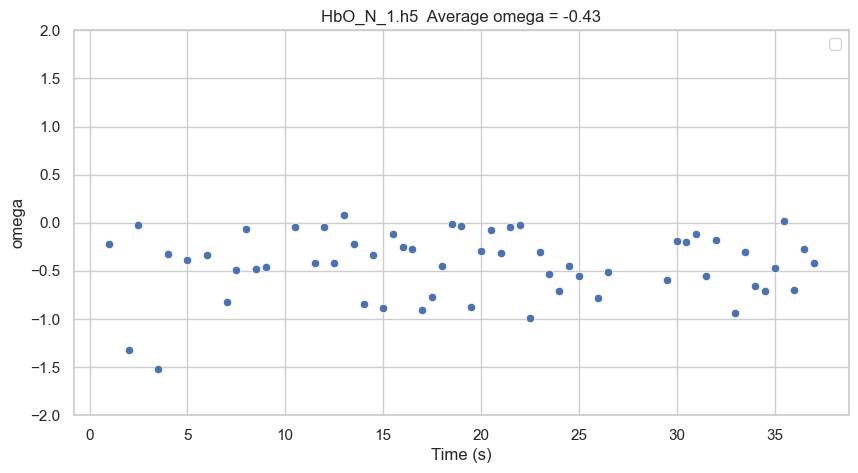

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


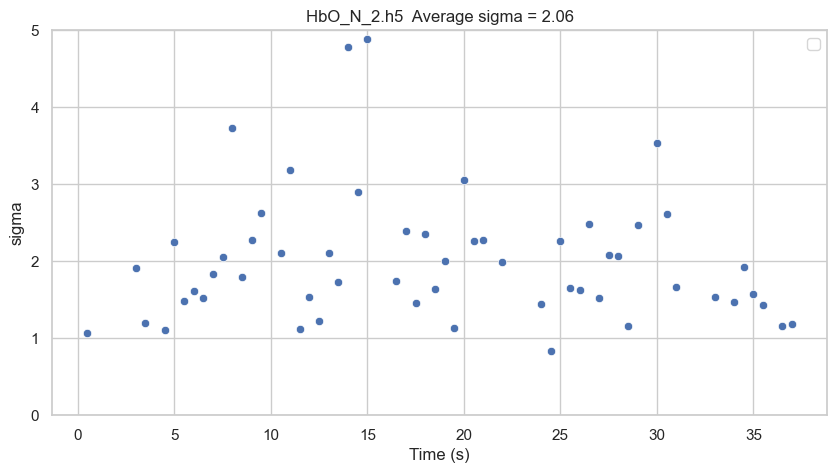

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


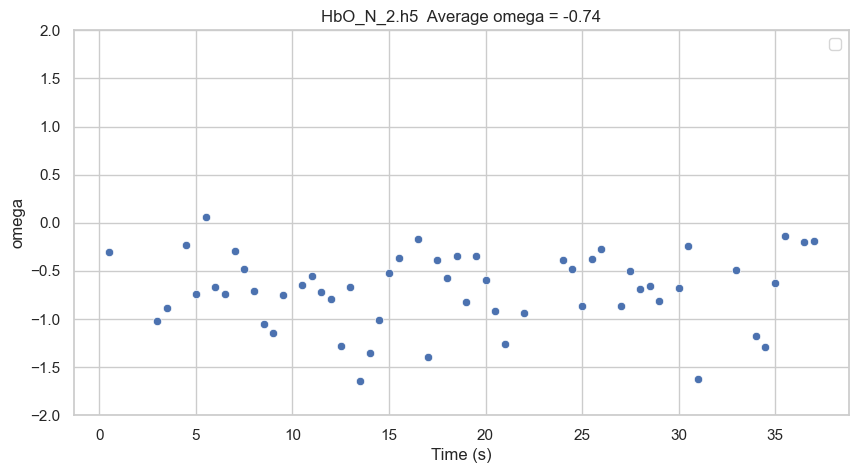

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


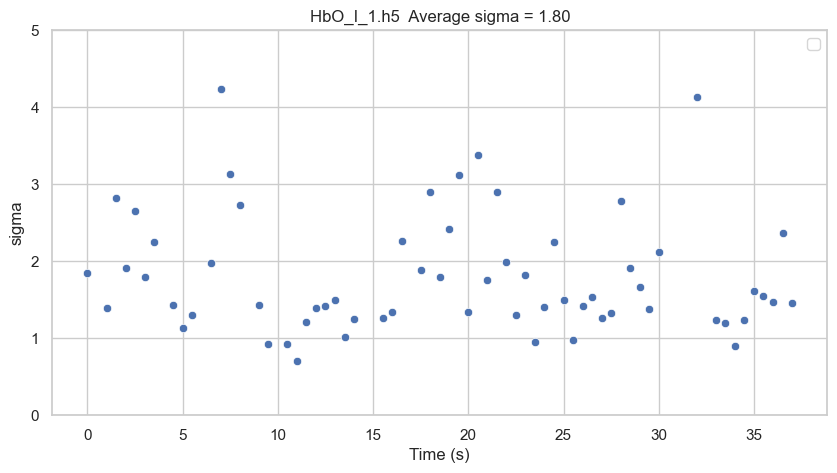

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


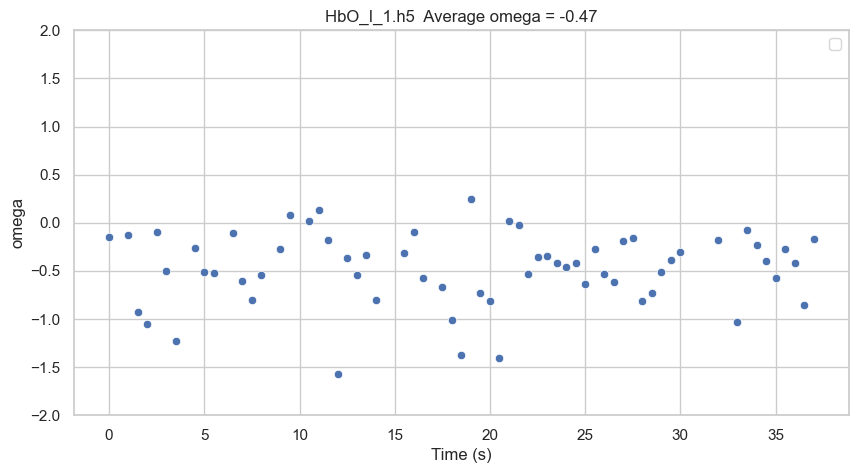

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


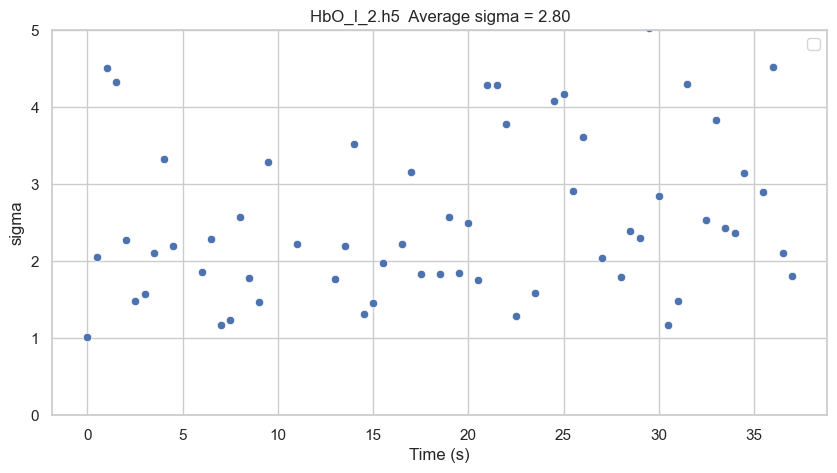

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


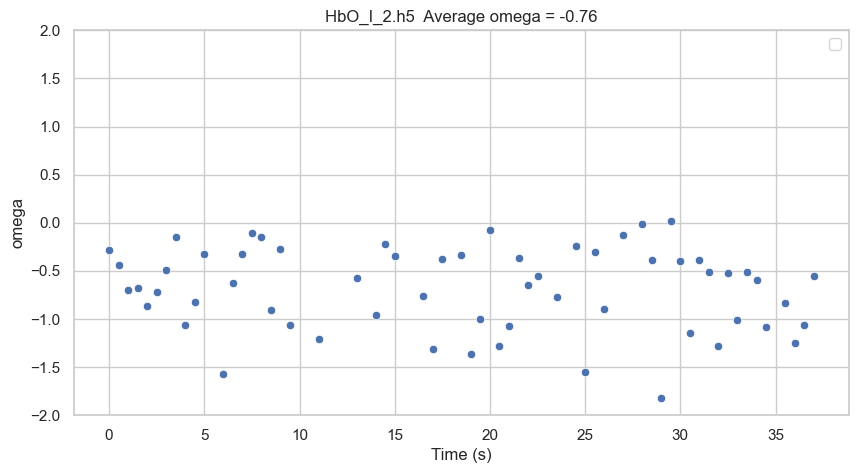

t test between N1 and N2
T-statistic: -3.2794520518336263, P-value: 0.002065800250141752
T-statistic: 3.7952230271606084, P-value: 0.0004571144242500943
t test between I1 and I2
T-statistic: -4.161000441454858, P-value: 0.00012178639214199519
T-statistic: 2.9569862017669024, P-value: 0.004697109665230556


In [25]:

def plot_coefficients(coefficients, time_interval, filename, coefficient_name):
    sns.set(style="whitegrid")
    
    time_points = np.arange(len(coefficients)) * time_interval
    coefficients = np.array([np.nan if c is None else c for c in coefficients])

    fig, ax = plt.subplots(figsize=(10, 5))
    sns.scatterplot(x=time_points, y=coefficients, legend="full", ax=ax)

    avg_coefficient = np.nanmean(coefficients)
    if "sigma" in coefficient_name:
        limit = (0,5)
    elif "omega" in coefficient_name:
        limit = (-2,2)
    plt.title(f'{filename}  Average {coefficient_name} = {avg_coefficient:.2f}')
    plt.ylim(limit)
    plt.xlabel('Time (s)')
    plt.ylabel(coefficient_name)
    plt.legend()
    plt.show()
    plt.close(fig)


# Call the function for all files
for idx, file_path in enumerate(h5_file_paths):    
    filename = filename = file_path.split('/')[-1]
    plot_coefficients(coefficients_files[idx][0],  time_interval, filename=filename, coefficient_name="sigma" )
    plot_coefficients(coefficients_files[idx][1],  time_interval, filename=filename , coefficient_name="omega")






In [27]:
def t_test_coefficients(coefficients_a,coefficients_b):
    df = pd.DataFrame({
        'a' : coefficients_a,
        'b' : coefficients_b
    })
    df.dropna(inplace=True)

    if df['a'].var() != 0 and df['b'].var() != 0 and not df.empty:
        t_statistic, p_value = stats.ttest_rel(df['a'], df['b'])
        print(f"T-statistic: {t_statistic}, P-value: {p_value}")
    else:
        print("Data is not suitable for t-test")
print("t test between N1 and N2")

t_test_coefficients(coefficients_files[0][0],coefficients_files[1][0])
t_test_coefficients(coefficients_files[0][1],coefficients_files[1][1])

print("t test between I1 and I2")
t_test_coefficients(coefficients_files[2][0],coefficients_files[3][0])
t_test_coefficients(coefficients_files[2][1],coefficients_files[3][1])


print("t test between N1 and I1")

t_test_coefficients(coefficients_files[0][0],coefficients_files[2][0])
t_test_coefficients(coefficients_files[0][1],coefficients_files[2][1])

print("t test between N2 and I2")
t_test_coefficients(coefficients_files[1][0],coefficients_files[3][0])
t_test_coefficients(coefficients_files[1][1],coefficients_files[3][1])


t test between N1 and N2
T-statistic: -3.2794520518336263, P-value: 0.002065800250141752
T-statistic: 3.7952230271606084, P-value: 0.0004571144242500943
t test between I1 and I2
T-statistic: -4.161000441454858, P-value: 0.00012178639214199519
T-statistic: 2.9569862017669024, P-value: 0.004697109665230556
t test between N1 and I1
T-statistic: -1.2364867426679458, P-value: 0.22229390600660964
T-statistic: 1.2700277342077895, P-value: 0.21019703497989298
t test between N2 and I2
T-statistic: -1.899695784644647, P-value: 0.06361881182060569
T-statistic: 0.9343825834032651, P-value: 0.3548825288065979


***Step 5: plot nodes properties over time***

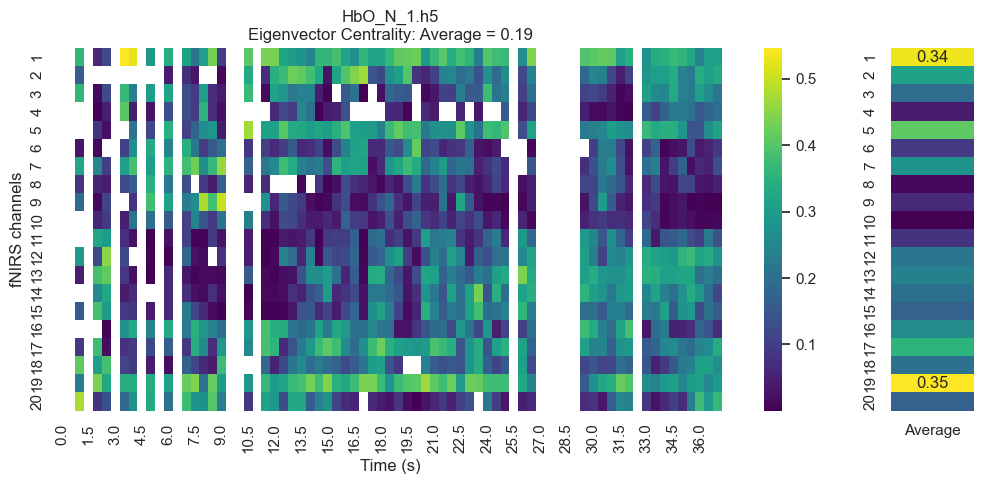

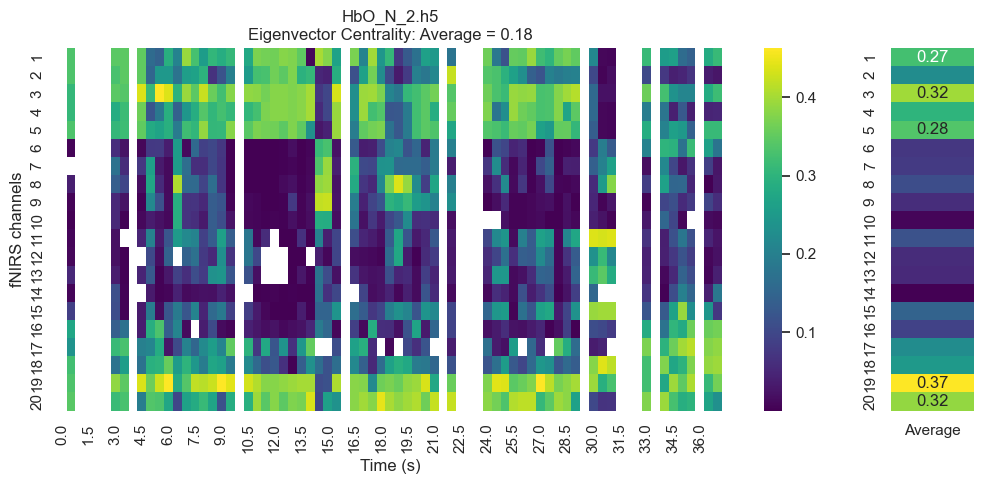

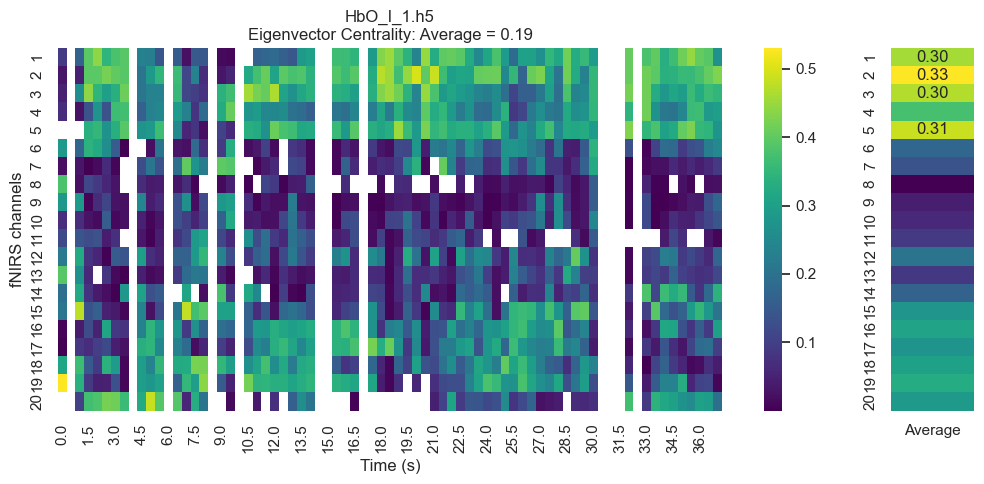

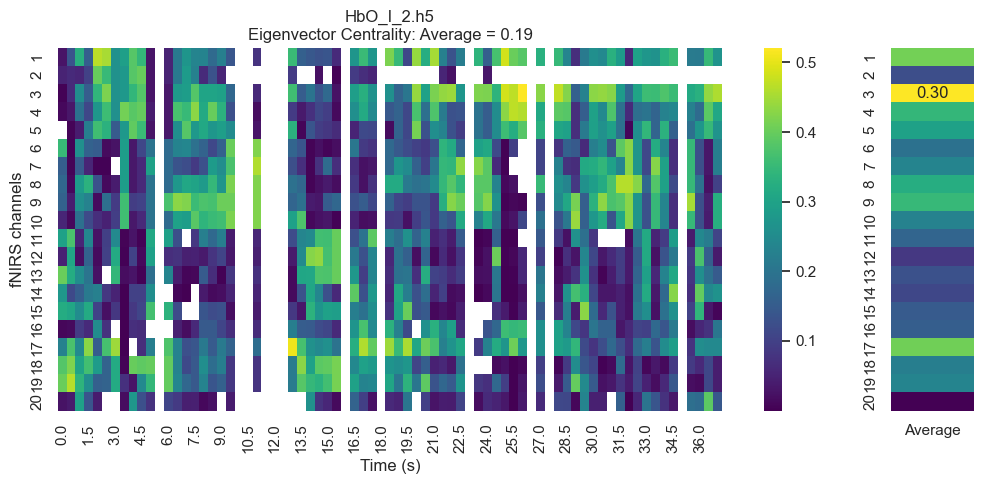

In [10]:
import matplotlib.gridspec as gridspec
def plot_heatmap_with_avg_bar(signal, time_interval, property_name, filename, col, total_cols):
   
    signal.index = range(1, len(signal) + 1)

    time_points = np.arange(signal.shape[1]) * time_interval
    #time_points = time_points[::2]
    
    # Manage the time labels to space out them correctly
    label_step = len(time_points) // 20  
    time_labels = [f"{t}" if i % label_step == 0 else '' for i, t in enumerate(time_points)]

    # Setup gridspec
    width_ratios = [10, 1] * total_cols
    gs = gridspec.GridSpec(1, total_cols * 2 , width_ratios=width_ratios) 

    # Main heatmap subplot
    ax1 = plt.subplot(gs[0, col * 2 - 2:col * 2 - 1])
    sns.heatmap(signal, annot=False, cmap='viridis', ax=ax1, xticklabels=time_labels)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("fNIRS channels")
    

    # Average heatmap subplot (narrow)
    avg_df = signal.stack().mean()
    ax2 = plt.subplot(gs[0, col * 2 - 1])
    avg_channel = pd.DataFrame(signal.mean(axis=1), columns=['Average'])
    annotations = np.where(avg_channel > 1.5 * avg_df, avg_channel, None)
    formatted_annotations = [[f"{val:.2f}" if val is not None else "" for val in row] for row in annotations]    
    sns.heatmap(avg_channel, cmap='viridis', cbar=False, ax=ax2, annot=formatted_annotations, fmt='')
    #ax2.set_yticks([])  # Hide y-axis labels

    ax1.set_title(f"{filename}\n{property_name}: Average = {avg_df:.2f}" if col == 1 else property_name)


    plt.tight_layout()
    plt.show()
    plt.close()

total_properties = 1  # eigenvector centrality

for index, prop in enumerate(properties_list):
    filename = h5_file_paths[index].split('/')[-1]

    # Create a figure for each file
    plt.figure(figsize=(10, 5))  

    # Load the properties into a DataFrame and drop non-dict columns
    df = pd.DataFrame(prop)
    df = df.drop(columns=['average_clustering', 'average_shortest_path_length', 'largest_cc_size'])

    # Process and plot each property
    # eigenvector centrality
    eigenvector_df = df['eigenvector_centrality'].apply(pd.Series)
    eigenvector_df.columns = pd.to_numeric(eigenvector_df.columns)
    eigenvector_df = eigenvector_df.sort_index(axis=1)
    plot_heatmap_with_avg_bar(eigenvector_df.T, time_interval, 'Eigenvector Centrality', filename, 1, total_properties)

    #betweenness centrality
    betweenness_df = df['betweenness_centrality'].apply(pd.Series)
    betweenness_df.columns = pd.to_numeric(betweenness_df.columns)
    betweenness_df = betweenness_df.sort_index(axis=1)
    # uncomment the following to plot betweenness heatmaps and comment the eigenvector one
    #plot_heatmap_with_avg_bar(betweenness_df.T, time_interval, 'Betweenness Centrality', filename, 1, total_properties)







